* PAPER - An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale - [PDF](https://arxiv.org/pdf/2010.11929.pdf)
* PAPER - When Shift Operation Meets Vision Transformer: An Extremely Simple Alternative to Attention Mechanism - [PDF](https://arxiv.org/pdf/2201.10801.pdf
* PAPER - A ConvNet for the 2020s - [PDF](https://arxiv.org/pdf/2201.03545.pdf)
* PAPER - How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers - [PDF](https://arxiv.org/pdf/2106.10270.pdf)
* PAPER - Deep Networks with Stochastic Depth - [PDF](https://arxiv.org/pdf/1603.09382.pdf)
* <span class="mark">PAPER - Training data-efficient image transformers & distillation through attention - [PDF](https://arxiv.org/pdf/2012.12877.pdf)</span> 

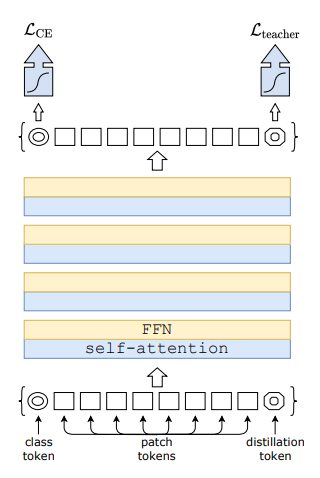

# 준비

## 라이브러리 호출

In [1]:
from typing import List

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

tfds.disable_progress_bar()
tf.keras.utils.set_random_seed(42)

## 하이퍼 파라미터

In [2]:
# Model
MODEL_TYPE = "deit_distilled_tiny_patch16_224"
RESOLUTION = 224
PATCH_SIZE = 16
NUM_PATCHES = (RESOLUTION // PATCH_SIZE) ** 2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 192
NUM_HEADS = 3
NUM_LAYERS = 12
MLP_UNITS = [
    PROJECTION_DIM * 4,
    PROJECTION_DIM,
]
DROPOUT_RATE = 0.0
DROP_PATH_RATE = 0.1

# Training
NUM_EPOCHS = 20
BASE_LR = 0.0005
WEIGHT_DECAY = 0.0001

# Data
BATCH_SIZE = 2
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 5

## 데이터 셋

In [3]:
def preprocess_dataset(is_training=True):
    def fn(image, label):
        if is_training:
            # Resize to a bigger spatial resolution and take the random
            # crops.
            image = tf.image.resize(image, (RESOLUTION + 20, RESOLUTION + 20))
            image = tf.image.random_crop(image, (RESOLUTION, RESOLUTION, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
        label = tf.one_hot(label, depth=NUM_CLASSES)
        return image, label

    return fn


def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(BATCH_SIZE * 10)
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=AUTO)
    return dataset.batch(BATCH_SIZE).prefetch(AUTO)


train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)
num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

train_dataset = prepare_dataset(train_dataset, is_training=True)
val_dataset = prepare_dataset(val_dataset, is_training=False)

3.0.0
Using ~\tensorflow_datasets\tf_flowers\3.0.1 instead.


Number of training examples: 3303
Number of validation examples: 367


# 모델

## StochasticDepth

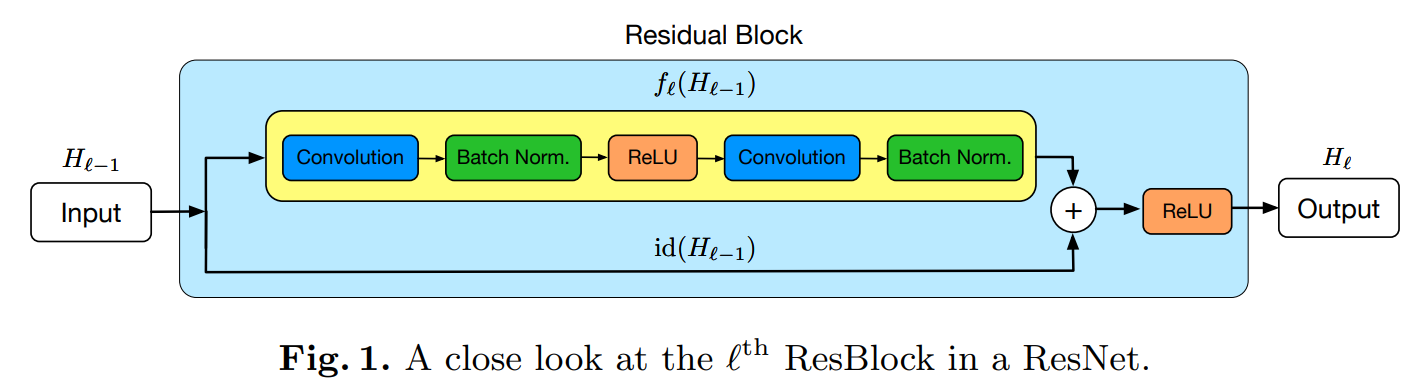
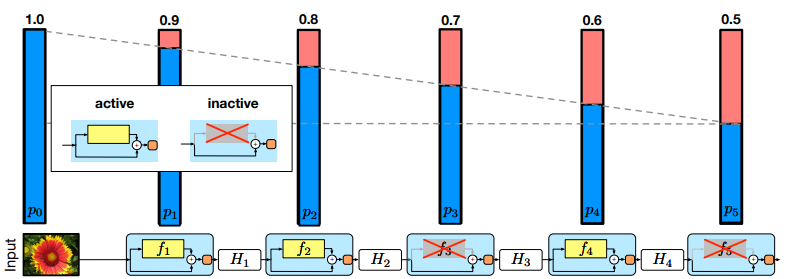

In [4]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=True):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

## MLP

In [5]:
def mlp(x, dropout_rate: float, hidden_units: List):
    """FFN for a Transformer block."""
    # Iterate over the hidden units and
    # add Dense => Dropout.
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

## Transformer

In [6]:
def transformer(drop_prob: float, name: str) -> keras.Model:
    """Transformer block with pre-norm."""
    num_patches = NUM_PATCHES + 2 if "distilled" in MODEL_TYPE else NUM_PATCHES + 1
    encoded_patches = layers.Input((num_patches, PROJECTION_DIM))

    # Layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)

    # Multi Head Self Attention layer 1.
    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=PROJECTION_DIM,
        dropout=DROPOUT_RATE,
    )(x1, x1)
    attention_output = (
        StochasticDepth(drop_prob)(attention_output) if drop_prob else attention_output
    )

    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])

    # Layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

    # MLP layer 1.
    x4 = mlp(x3, hidden_units=MLP_UNITS, dropout_rate=DROPOUT_RATE)
    x4 = StochasticDepth(drop_prob)(x4) if drop_prob else x4

    # Skip connection 2.
    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, outputs, name=name)

## ViTClassifier

In [7]:
class ViTClassifier(keras.Model):
    """Vision Transformer base class."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        # Patchify + linear projection + reshaping.
        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=PROJECTION_DIM,
                    kernel_size=(PATCH_SIZE, PATCH_SIZE),
                    strides=(PATCH_SIZE, PATCH_SIZE),
                    padding="VALID",
                    name="conv_projection",
                ),
                layers.Reshape(
                    target_shape=(NUM_PATCHES, PROJECTION_DIM),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        # Positional embedding.
        init_shape = (
            1,
            NUM_PATCHES + 1,
            PROJECTION_DIM,
        )
        self.positional_embedding = tf.Variable(tf.zeros(init_shape),
                                                name="pos_embedding")

        # Transformer blocks.
        dpr = [x for x in tf.linspace(0.0, DROP_PATH_RATE, NUM_LAYERS)]
        self.transformer_blocks = [
            transformer(drop_prob=dpr[i], name=f"transformer_block_{i}")
            for i in range(NUM_LAYERS)
        ]

        # CLS token.
        initial_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.cls_token = tf.Variable(initial_value=initial_value,
                                     trainable=True,
                                     name="cls")

        # Other layers.
        self.dropout = layers.Dropout(DROPOUT_RATE)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append class token if needed.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        # Add positional embeddings to the projected patches.
        encoded_patches = (self.positional_embedding + projected_patches
                           )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Pool representation.
        encoded_patches = representation[:, 0]

        # Classification head.
        output = self.head(encoded_patches)
        return output

## ViTDistilled

In [8]:
class ViTDistilled(ViTClassifier):

    def __init__(self, regular_training=False, **kwargs):
        super().__init__(**kwargs)
        self.num_tokens = 2
        self.regular_training = regular_training

        # CLS and distillation tokens, positional embedding.
        init_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.dist_token = tf.Variable(init_value, name="dist_token")
        self.positional_embedding = tf.Variable(
            tf.zeros((
                1,
                NUM_PATCHES + self.num_tokens,
                PROJECTION_DIM,
            )),
            name="pos_embedding",
        )

        # Head layers.
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )
        self.head_dist = layers.Dense(
            NUM_CLASSES,
            name="distillation_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        # Create patches and project the patches.
        projected_patches = self.projection(inputs)

        # Append the tokens.
        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        dist_token = tf.tile(self.dist_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        dist_token = tf.cast(dist_token, projected_patches.dtype)
        projected_patches = tf.concat(
            [cls_token, dist_token, projected_patches], axis=1)

        # Add positional embeddings to the projected patches.
        encoded_patches = (self.positional_embedding + projected_patches
                           )  # (B, number_patches, projection_dim)
        encoded_patches = self.dropout(encoded_patches)

        # Iterate over the number of layers and stack up blocks of
        # Transformer.
        for transformer_module in self.transformer_blocks:
            # Add a Transformer block.
            encoded_patches = transformer_module(encoded_patches)

        # Final layer normalization.
        representation = self.layer_norm(encoded_patches)

        # Classification heads.
        x, x_dist = (
            self.head(representation[:, 0]),
            self.head_dist(representation[:, 1]),
        )

        if not training or self.regular_training:
            # During standard train / finetune, inference average the classifier
            # predictions.
            return (x + x_dist) / 2

        elif training:
            # Only return separate classification predictions when training in distilled
            # mode.
            return x, x_dist

## DeiT

* CE is cross-entropy
* psi is the softmax function
* Z_s denotes student predictions
* y denotes true labels
*y_t denotes teacher predictions

In [9]:
class DeiT(keras.Model):
    # Reference:
    # https://keras.io/examples/vision/knowledge_distillation/
    def __init__(self, student, teacher, **kwargs):
        super().__init__(**kwargs)
        self.student = student
        self.teacher = teacher

        self.student_loss_tracker = keras.metrics.Mean(name="student_loss")
        self.dist_loss_tracker = keras.metrics.Mean(name="distillation_loss")

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.student_loss_tracker)
        metrics.append(self.dist_loss_tracker)
        return metrics

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        # Unpack data.
        x, y = data

        # Forward pass of teacher
        teacher_predictions = tf.nn.softmax(self.teacher(x, training=False), -1)
        teacher_predictions = tf.argmax(teacher_predictions, -1)

        with tf.GradientTape() as tape:
            # Forward pass of student.
            cls_predictions, dist_predictions = self.student(x / 255.0, training=True)

            # Compute losses.
            student_loss = self.student_loss_fn(y, cls_predictions)
            distillation_loss = self.distillation_loss_fn(
                teacher_predictions, dist_predictions
            )
            loss = (student_loss + distillation_loss) / 2

        # Compute gradients.
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights.
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics configured in `compile()`.
        student_predictions = (cls_predictions + dist_predictions) / 2
        self.compiled_metrics.update_state(y, student_predictions)
        self.dist_loss_tracker.update_state(distillation_loss)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        # Unpack the data.
        x, y = data

        # Compute predictions.
        y_prediction = self.student(x / 255.0, training=False)

        # Calculate the loss.
        student_loss = self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        self.student_loss_tracker.update_state(student_loss)

        # Return a dict of performance.
        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        return self.student(inputs / 255.0, training=False)

## Load Teacher model

In [ ]:
# import requests
# import shutil
# url = 'https://github.com/sayakpaul/deit-tf/releases/download/v0.1.0/bit_teacher_flowers.zip'
# r = requests.get(url, stream=True)
# path_to_save = "D:Dataset/weights/bit_teacher_flowers.zip"
# with open(path_to_save, 'wb') as f:
#     shutil.copyfileobj(r.raw, f)  

In [ ]:
# import zipfile
# with zipfile.ZipFile(path_to_save, 'r') as zip_ref:
#     zip_ref.extractall("D:Dataset/weights/")

In [10]:
bit_teacher_flowers = keras.models.load_model("D:Dataset/weights/bit_teacher_flowers")

# 훈련

## Distillation 을 이용한 Training

In [11]:
deit_tiny = ViTDistilled()
deit_distiller = DeiT(student=deit_tiny, teacher=bit_teacher_flowers)

lr_scaled = (BASE_LR / 512) * BATCH_SIZE
deit_distiller.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
    metrics=["accuracy"],
    student_loss_fn=keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1
    ),
    distillation_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
_ = deit_distiller.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS)

Epoch 1/20
1652/1652 [==============================] - 264s 151ms/step - accuracy: 0.3312 - student_loss: 1.5273 - distillation_loss: 1.4921 - val_accuracy: 0.3651 - val_student_loss: 1.4789 - val_distillation_loss: 0.0000e+00
Epoch 2/20
1652/1652 [==============================] - 252s 153ms/step - accuracy: 0.3772 - student_loss: 1.4426 - distillation_loss: 1.3941 - val_accuracy: 0.4142 - val_student_loss: 1.4139 - val_distillation_loss: 0.0000e+00
Epoch 3/20
1652/1652 [==============================] - 252s 152ms/step - accuracy: 0.4229 - student_loss: 1.3820 - distillation_loss: 1.3170 - val_accuracy: 0.4441 - val_student_loss: 1.3375 - val_distillation_loss: 0.0000e+00
Epoch 4/20
1652/1652 [==============================] - 256s 155ms/step - accuracy: 0.4675 - student_loss: 1.3292 - distillation_loss: 1.2577 - val_accuracy: 0.4905 - val_student_loss: 1.3007 - val_distillation_loss: 0.0000e+00
Epoch 5/20
1652/1652 [==============================] - 250s 151ms/step - accuracy: 0.49